# хязгаарлагдсан Болцман машин (restricted Boltzmann machine) 

Болцман машин бол нуугдмал (hidden, $\textbf{h}$) ба ил (visible, $\textbf{v}$) давхаргын цэгүүдээс бүрдэх Марковын санамсаргүй орны (Markov Random Field) тухайн тохиолдол юм (Доорх зургийг харна уу (Kevin P Murphy: Machine Learning)).

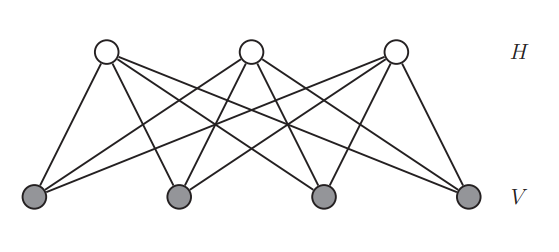

In [7]:
from IPython.display import Image
Image(filename='markov.png')

Болцманы машины хувьд ижил нэг давхаргад байгаа элементүүдийн хооронд харилцан хобоогүй бөгөөд харин өөр давхарга хооронд харилцан холбоотой байдаг төдийгүй Модел маань доорх байдлаар тодорхойлогдоно
$$ p(\textbf{h},\textbf{v}| \textbf{w})=\frac{1}{Z(\textbf{w})}\prod_{r=1}^{R}\prod_{k=1}^{K}\psi(v_{r},h_{k}).$$
Нуугдсан болон ил хувьсагч нь зөвхөн 0 эсвэл 1 утгыг авхаар зөвшөөрөгдсөн. Ил хувьсагч буюу оролтын өгөгдөл дутуу үед тухайн дутуу өгөгдөл нуугдсан хувьсагчид агуулагдаж байгаа хэмээн үзэж магадлалыг хамгийн их буюу 1-тэй ойрхон байх параметр $w$-ын утгыг олох нь хамгийн гол зорилго юм. Өгөгдсөн функц $ \prod_{r=1}^{R}\prod_{k=1}^{K}\psi(v_{r},h_{k})=\exp(-E(\textbf{h},\textbf{v}; \textbf{w}))$ нь энергийн функцээр тодорхойлогддог гэж үзвэл,   

$$ p(\textbf{h},\textbf{v}| \textbf{w})=\frac{1}{Z(\textbf{w})}\exp(-E(\textbf{h},\textbf{v}; \textbf{w})),$$
хэлбэртэй болно. Болцманы машины хувьд энергийн функц нь доорх хэлбэртэй
$$E(\textbf{h},\textbf{v}; \textbf{w})=-\sum_{r=1}^R\sum_{k=1}^K v_r h_k W_rk-\sum_{r=1}^R v_r b_r-\sum_{k=1}^K h_k c_k\\=-(\textbf{v}^T \textbf{W}\textbf{v}+\textbf{v}^T\textbf{b}+\textbf{h}^T \textbf{c})$$

Дээрх моделийн хувьд нэгэн чухал шинж чанар бол өгөгдсөн ил утга болон параметрийн хувьд нэг нэгнээсээ хамаардаггүй болно, $$ p(\textbf{h}|\textbf{v}, \textbf{w})=\prod_{k}p(h_{k}| \textbf{v}, \textbf{w})
\\=\prod_k Ber(h_k | sigm(\textbf{w}_{:,k}^T\textbf{v})).$$

Харин ил утга маань өгөгдсөн далд болон параметрийн хувьд ижилхэн байдлаар илэрхийлэх боломжтой,
$$ p(\textbf{v}|\textbf{h}, \textbf{w})=\prod_{r}p(v_{r}| \textbf{h}, \textbf{w})
\\=\prod_r Ber(v_r | sigm(\textbf{w}_{r,:}^T\textbf{h})),$$
энд Ber-(Bernouli) ба sigm-(sigmoid) функцүүд юм.

# Жишээ: 

Гүйцэтгэж буй алгоритм:

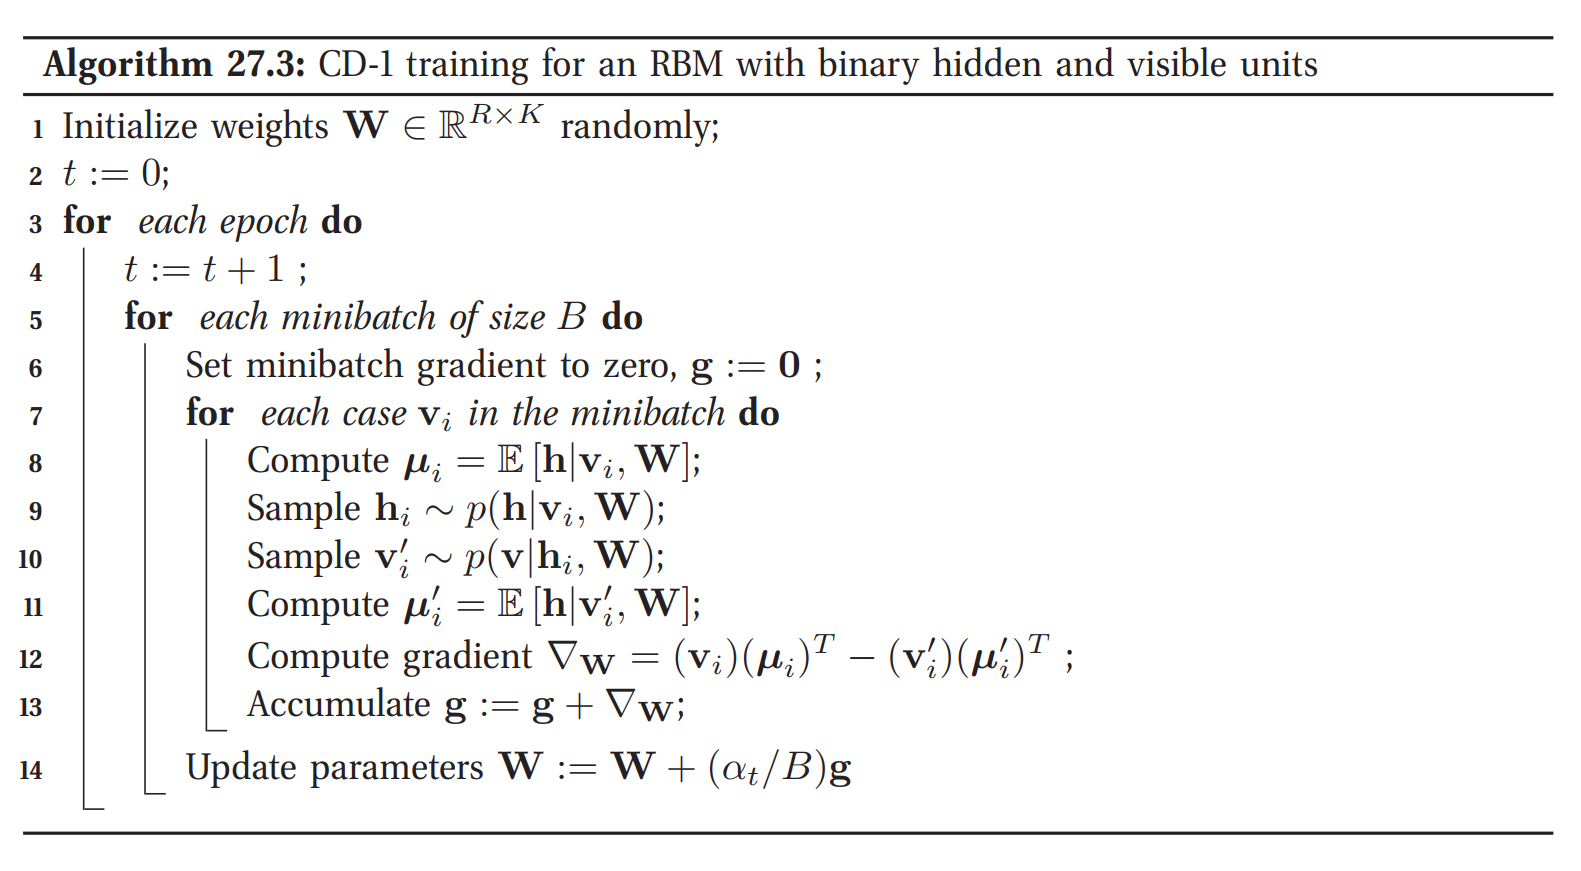

In [8]:
Image(filename='cd_rbm.png')

#source: Kevin P Murphy, Machine learning: A Probabilistic Perspective

In [1]:
import numpy 
import math as mt
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import dimod

In [2]:
import sys

In [3]:
#http://deeplearning.net/tutorial/rbm.html
numpy.seterr(all='ignore')

def sigmoid(x):
    return 1. / (1 + numpy.exp(-x))

In [4]:
class RBM(object):
    def __init__(self, input=None, n_visible=2, n_hidden=3, \
        W=None, hbias=None, vbias=None, numpy_rng=None):
        
        self.n_visible = n_visible  # num of units in visible (input) layer
        self.n_hidden = n_hidden    # num of units in hidden layer

        if numpy_rng is None:
            numpy_rng = numpy.random.RandomState(1234)


        if W is None:
            a = 1. / n_visible
            initial_W = numpy.array(numpy_rng.uniform(  # initialize W uniformly
                low=-a,
                high=a,
                size=(n_visible, n_hidden)))

            W = initial_W

        if hbias is None:
            hbias = numpy.zeros(n_hidden)  # initialize h bias 0

        if vbias is None:
            vbias = numpy.zeros(n_visible)  # initialize v bias 0


        self.numpy_rng = numpy_rng
        self.input = input
        self.W = W
        self.hbias = hbias
        self.vbias = vbias

        # self.params = [self.W, self.hbias, self.vbias]
    def contrastive_divergence(self, lr=0.1, k=1, input=None):
        if input is not None:
            self.input = input
        ph_mean, ph_sample = self.sample_h_given_v(self.input)
        chain_start = ph_sample

        for step in range(k):
            if step == 0:
                nv_means, nv_samples,\
                nh_means, nh_samples = self.gibbs_hvh(chain_start)
            else:
                nv_means, nv_samples,\
                nh_means, nh_samples = self.gibbs_hvh(nh_samples)

                # chain_end = nv_samples


        self.W += lr * (numpy.dot(self.input.T, ph_sample)
                                - numpy.dot(nv_samples.T, nh_means))
        self.vbias += lr * numpy.mean(self.input - nv_samples, axis=0)
        self.hbias += lr * numpy.mean(ph_sample - nh_means, axis=0)

            # cost = self.get_reconstruction_cross_entropy()
            # return cost
            
    def sample_h_given_v(self, v0_sample):
                h1_mean = self.propup(v0_sample)
                h1_sample = self.numpy_rng.binomial(size=h1_mean.shape,   # discrete: binomial
                                           n=1,
                                           p=h1_mean)
                
                return [h1_mean, h1_sample]


    def sample_v_given_h(self, h0_sample):
                v1_mean = self.propdown(h0_sample)#
                v1_sample = self.numpy_rng.binomial(size=v1_mean.shape,   # discrete: binomial
                                                n=1,
                                                p=v1_mean)
        
                return [v1_mean, v1_sample]

    def propup(self, v):
                pre_sigmoid_activation = numpy.dot(v, self.W) + self.hbias
                return sigmoid(pre_sigmoid_activation)

    def propdown(self, h):
                pre_sigmoid_activation = numpy.dot(h, self.W.T) + self.vbias
                return sigmoid(pre_sigmoid_activation)


    def gibbs_hvh(self, h0_sample):
                v1_mean, v1_sample = self.sample_v_given_h(h0_sample)
                h1_mean, h1_sample = self.sample_h_given_v(v1_sample)

                return [v1_mean, v1_sample,
                        h1_mean, h1_sample]


    def get_reconstruction_cross_entropy(self):
                pre_sigmoid_activation_h = numpy.dot(self.input, self.W) + self.hbias
                sigmoid_activation_h = sigmoid(pre_sigmoid_activation_h)

                pre_sigmoid_activation_v = numpy.dot(sigmoid_activation_h, self.W.T) + self.vbias
                sigmoid_activation_v = sigmoid(pre_sigmoid_activation_v)

                cross_entropy =  - numpy.mean(
                    numpy.sum(self.input * numpy.log(sigmoid_activation_v) +
                    (1 - self.input) * numpy.log(1 - sigmoid_activation_v),
                              axis=1))

                return cross_entropy

    def reconstruct(self, v):
                h = sigmoid(numpy.dot(v, self.W) + self.hbias)
                reconstructed_v = sigmoid(numpy.dot(h, self.W.T) + self.vbias)
                return reconstructed_v

In [5]:
def test_rbm(learning_rate=0.1, k=1, training_epochs=1000):
    data = numpy.array([[1,1,1,0,0,0],
                        [1,0,1,0,0,0],
                        [1,1,1,0,0,0],
                        [0,0,1,1,1,0],
                        [0,0,1,1,0,0],
                        [0,0,1,1,1,0]])



    rng = numpy.random.RandomState(123)

    # construct RBM
    rbm = RBM(input=data, n_visible=6, n_hidden=2, numpy_rng=rng)

    # train
    for epoch in range(training_epochs):
        rbm.contrastive_divergence(lr=learning_rate, k=k)
        cost = rbm.get_reconstruction_cross_entropy()
        print('Training epoch %d, cost is ' % epoch, cost)


    # test
    v = numpy.array([[0, 0, 0, 1, 1, 0],
                     [1, 1, 0, 0, 0, 0]])

    print(np.around(rbm.reconstruct(v),2))


if __name__ == "__main__":
    test_rbm()

Training epoch 0, cost is  3.8404525320116316
Training epoch 1, cost is  3.6030057205387886
Training epoch 2, cost is  3.344840988642098
Training epoch 3, cost is  3.1888242492436247
Training epoch 4, cost is  3.070989031621917
Training epoch 5, cost is  2.987422874508091
Training epoch 6, cost is  2.929312509816723
Training epoch 7, cost is  2.901390298881347
Training epoch 8, cost is  2.9131964254363987
Training epoch 9, cost is  2.8832716368804547
Training epoch 10, cost is  2.819981768052298
Training epoch 11, cost is  2.7596178172283516
Training epoch 12, cost is  2.6637689428723808
Training epoch 13, cost is  2.62014579454439
Training epoch 14, cost is  2.6248578887924894
Training epoch 15, cost is  2.5964701103505443
Training epoch 16, cost is  2.582490708351225
Training epoch 17, cost is  2.4871823996985825
Training epoch 18, cost is  2.3905737044907283
Training epoch 19, cost is  2.4036810513800844
Training epoch 20, cost is  2.356291860119786
Training epoch 21, cost is  2.325

Training epoch 463, cost is  0.6856940632779769
Training epoch 464, cost is  0.6877333907057263
Training epoch 465, cost is  0.6898115999085904
Training epoch 466, cost is  0.6878354832103426
Training epoch 467, cost is  0.6896734927084781
Training epoch 468, cost is  0.6925421880872548
Training epoch 469, cost is  0.7101090053252014
Training epoch 470, cost is  0.6994905523087448
Training epoch 471, cost is  0.6978373575307502
Training epoch 472, cost is  0.6955166498763337
Training epoch 473, cost is  0.690191569018103
Training epoch 474, cost is  0.6837582060761708
Training epoch 475, cost is  0.693951110028242
Training epoch 476, cost is  0.6891368437532827
Training epoch 477, cost is  0.6838661568013543
Training epoch 478, cost is  0.6861465895237351
Training epoch 479, cost is  0.6926417703544563
Training epoch 480, cost is  0.6899189695476977
Training epoch 481, cost is  0.7035728967850569
Training epoch 482, cost is  0.6898795217637338
Training epoch 483, cost is  0.68352665214

Training epoch 956, cost is  0.577176110345709
Training epoch 957, cost is  0.5595881106293322
Training epoch 958, cost is  0.5508591517061404
Training epoch 959, cost is  0.5837362575730164
Training epoch 960, cost is  0.6076088546568971
Training epoch 961, cost is  0.5818084557090438
Training epoch 962, cost is  0.6019474750837126
Training epoch 963, cost is  0.5993735007853234
Training epoch 964, cost is  0.6031240220122341
Training epoch 965, cost is  0.6151262427977815
Training epoch 966, cost is  0.6255628503585419
Training epoch 967, cost is  0.6236208990281576
Training epoch 968, cost is  0.6189855324738651
Training epoch 969, cost is  0.6261538955337044
Training epoch 970, cost is  0.6187474841165395
Training epoch 971, cost is  0.6392379522189026
Training epoch 972, cost is  0.6351759956071473
Training epoch 973, cost is  0.6240657477238315
Training epoch 974, cost is  0.6051930444787635
Training epoch 975, cost is  0.5822855995410103
Training epoch 976, cost is  0.5771971326

NameError: name 'np' is not defined